# Prediction of house prices in Amsterdam

### Objective: predict the average value of a house (WOZ)

$
y_i = f(X_i'\beta) + \epsilon
$

### Metric used for predictive power: MSE

$ 
MSE = \frac{1}{n} \sum (y_i - \hat y_i)^2
$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statistics as st
import sklearn as sk
from sklearn.model_selection import train_test_split
from xgboost import XGBRFRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import difflib
import os

C:\Users\31648\AppData\Local\Temp\ipykernel_27400\1896093005.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
os.chdir('C:/Users/31648/Desktop/projects/AmsterdamHousingPrediction')
os.listdir()

['family_composition_2016_amsterdam.xlsx',
 'INDELING_BUURT.csv',
 'prediction.ipynb',
 'woz_prices_2015_amsterdam.xlsx']

In [3]:
df = pd.read_excel('family_composition_2016_amsterdam.xlsx', skiprows = 3, nrows = 481)
df.columns = pd.read_excel('family_composition_2016_amsterdam.xlsx', nrows = 1, skiprows = 1, header = 1).columns
df = df.set_index(['area'])
df.head()

,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,total
area,,,,,,,,
A00a Kop Zeedijk,458,42,113,12,12,27,19,683
A00b Oude Kerk e.o.,295,14,88,7,7,28,17,456
A00c Burgwallen Oost,638,58,184,32,33,38,35,1018
A00d Nes e.o.,145,12,49,7,5,5,14,237
A00e BG-terrein e.o.,270,23,55,21,8,18,4,399


In [4]:
woz = pd.read_excel('woz_prices_2015_amsterdam.xlsx', skiprows = 3, nrows = 481)
woz.columns = pd.read_excel('woz_prices_2015_amsterdam.xlsx', nrows = 1, skiprows = 1, header = 1).columns
woz = woz.set_index(['area'])
woz.head()

,average woz value,woz-value per m2
area,,
A00a Kop Zeedijk,251054,3851
A00b Oude Kerk e.o.,252232,3456
A00c Burgwallen Oost,267918,3777
A00d Nes e.o.,330604,3923
A00e BG-terrein e.o.,325435,3950


### Join the two dataframes

In [5]:
df = df.join(woz)

## Data processing

In [6]:
df = df.apply(pd.to_numeric, errors='coerce')

### Outlier check

array([[<Axes: title={'center': 'single'}>,
        <Axes: title={'center': 'married, no kids'}>,
        <Axes: title={'center': 'not married, no kids'}>],
       [<Axes: title={'center': 'married, with kids'}>,
        <Axes: title={'center': 'not married, with kids'}>,
        <Axes: title={'center': 'single parent'}>],
       [<Axes: title={'center': 'other'}>,
        <Axes: title={'center': 'total'}>,
        <Axes: title={'center': 'average woz value'}>],
       [<Axes: title={'center': 'woz-value per m2'}>, <Axes: >, <Axes: >]],
      dtype=object)

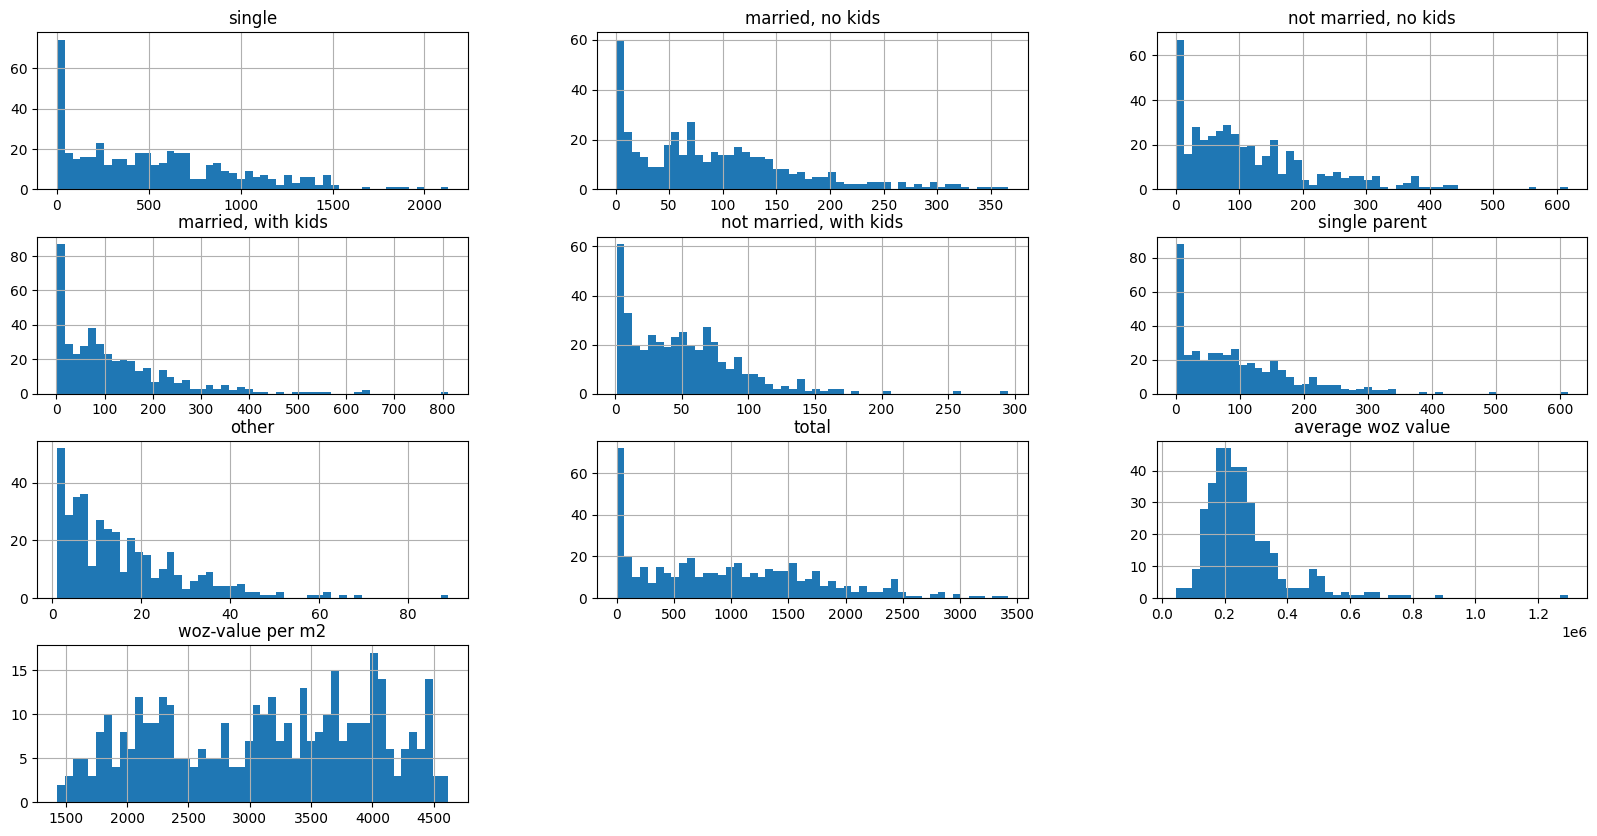

In [7]:
df.hist(bins=  50, figsize = (20,10))

It seems all variables behave quite well in terms of outliers

### Data cleaning

In [8]:
df.isna().sum()

single                    24
married, no kids          44
not married, no kids      45
married, with kids        53
not married, with kids    61
single parent             62
other                     84
total                     18
average woz value         99
woz-value per m2          99
dtype: int64

Clean missing values. In most variables we can input the mean without creating noise.

In [9]:
df = df.fillna(df.mean())

In [10]:
# Considering 'total' is a sum and variables will be presented as proportions we should be more careful.

df['total'] = df[['single', 'married, no kids', 'not married, no kids',
       'married, with kids', 'not married, with kids', 'single parent',
       'other']].sum(axis = 1)

# Feature selection

In [11]:
# City zone is included in area, it would be sensitive to think that house prices in the same zone are similar
df['stadsdeel'] = LabelEncoder().fit_transform(df.index.str[0])

# Average size may be a relevant variable as well
df['m2'] = df['average woz value'] / df['woz-value per m2']

# House prices between neighbourhoods are VERY likely to be spatially correlated. 

Thus, a random train/test split of the data would likely result in overfitting of the model. 

To correctly estimate a model, we can consider using a non random spatial split 

In [12]:
shp = pd.read_csv('INDELING_BUURT.csv', sep = ";")

In [13]:
# Text processing for match

shp['LNG'] = shp['LNG'].str.replace(".","")
shp['LNG'] = shp['LNG'].str[0] + '.' + shp['LNG'].str[0:]
shp['LNG'] = pd.to_numeric(shp['LNG'])

shp['LAT'] = shp['LAT'].str.replace(".","")
shp['LAT'] = shp['LAT'].str[0:2] + '.' + shp['LAT'].str[2:]
shp['LAT'] = pd.to_numeric(shp['LAT'])

shp['WKT_LNG_LAT'] = shp['WKT_LNG_LAT'].str.replace("POLYGON","")
shp['WKT_LNG_LAT'] = shp['WKT_LNG_LAT'].str.replace("(","")
shp['WKT_LNG_LAT'] = shp['WKT_LNG_LAT'].str.replace(")","")
shp['WKT_LNG_LAT'] = shp['WKT_LNG_LAT'].str.split(",")

shp['Buurt'] = shp['Buurt'].str.upper()

shp['Buurt'] = shp['Buurt'].str.replace(' OOST','-OOST')
shp['Buurt'] = shp['Buurt'].str.replace(' WEST','-WEST')
shp['Buurt'] = shp['Buurt'].str.replace(' NOORD','-NOORD')
shp['Buurt'] = shp['Buurt'].str.replace(' ZUID','-ZUID')
shp['Buurt'] = shp['Buurt'].str.replace(' MIDDEN','-MIDDEN')

shp = shp.rename(columns={"Buurt": "area"})

ind = df.index

df = df.reset_index()

df['area'] = df['area'].str.upper()
df['area'] = df['area'].str.split(" ", n = 1, expand = True)[1]

df['area'] = df['area'].str.replace(' OOST','-OOST')
df['area'] = df['area'].str.replace(' WEST','-WEST')
df['area'] = df['area'].str.replace(' NOORD','-NOORD')
df['area'] = df['area'].str.replace(' ZUID','-ZUID')
df['area'] = df['area'].str.replace(' MIDDEN','-MIDDEN')

# Replace areas with equivalent

df['area'] = df['area'].str.replace('ZUIDWESTKWADRANT OSDORP','ZUIDWESTKWADRANT')

df.loc[df.area == 'GOUDEN BOCHT', 'area'] = 'Geelvinckbuurt'.upper()
df.loc[df.area == 'VAN LOONBUURT', 'area'] = 'Vijzelstraatbuurt'.upper()
df.loc[df.area == 'REMBRANDTPLEINBUURT', 'area'] = 'REMBRANDTPLEIN E.O.'.upper()
df.loc[df.area == 'REGULIERSBUURT', 'area'] = 'Geelvinckbuurt'.upper()
df.loc[df.area == 'DE PLANTAGE', 'area'] = 'PLANTAGE'.upper()
df.loc[df.area == 'COENHAVEN/MERCURIUSHAVEN', 'area'] = 'COENHAVEN'.upper()
df.loc[df.area == 'ECOWIJK', 'area'] = 'WG-TERREIN'.upper()
df.loc[df.area == 'HOLENDRECHT-NOORDWEST', 'area'] = 'BUIKSLOTERDIJK-WEST'.upper()
df.loc[df.area == 'DE HEINING', 'area'] = 'HOLENDRECHT-OOST'.upper()
df.loc[df.area == 'K-BUURT-MIDDEN', 'area'] = 'Kelbergen'.upper()
df.loc[df.area == 'LOUIS CHRISPIJNBUURT', 'area'] = 'LOUIS CRISPIJNBUURT'.upper()
df.loc[df.area == 'ZAMENHOFSTRAAT E.O.', 'area'] = 'Hamerstraatkwartier-Oost'.upper()
df.loc[df.area == 'BEDRIJVENTERREIN HAMERSTRAAT', 'area'] = 'Hamerstraatkwartier-West'.upper()
df.loc[df.area == 'DE PUNT', 'area'] = 'BEDRIJVENCENTRUM OSDORP'.upper()
df.loc[df.area == 'CORNELIS DOUWESTERREIN', 'area'] = 'CORNELIS DOUWESTERREIN-WEST'.upper()
df.loc[df.area == 'PAPAVERWEG E.O.', 'area'] = 'Bloemenbuurt-Zuid'.upper()
df.loc[df.area == 'BUIKSLOTERHAM', 'area'] = 'Buiksloterham-Zuid'.upper()
df.loc[df.area == 'STRANDEILAND', 'area'] = 'Buiteneiland'.upper()
df.loc[df.area == 'NIEUWE DIEP/DIEMERPARK', 'area'] = 'Bovendiep/Diemerpark'.upper()
df.loc[df.area == 'JOHANNNES VERMEERBUURT', 'area'] = 'JOHANNES VERMEERBUURT'.upper()
df.loc[df.area == 'RI-OOST TERREIN', 'area'] = 'Sportheldenbuurt'.upper()
df.loc[df.area == 'BEDRIJVENGEBIED CRUQUIUSWEG', 'area'] = 'Cruquiusbuurt'.upper()
df.loc[df.area == 'BUITENVELDERT-MIDDEN-ZUID', 'area'] = 'Buitenveldert-Zuid-Midden'.upper()
df.loc[df.area == 'SWAMMERDAMBUURT', 'area'] = 'Weesperzijde-Midden/Zuid'.upper()
df.loc[df.area == 'SLOTERMEER-ZUID', 'area'] = 'BUIKSLOTERMEER-NOORD'.upper()
df.loc[df.area == 'TELEPORT', 'area'] = 'Sloterdijk Stationskwartier'.upper()

df.loc[df.area.str.contains('SLOTERDIJK'), 'area'] = 'BUIKSLOTERDIJK-WEST'
df.loc[df.area.str.contains('GEIN'), 'area'] = 'GEIN 1'
df.loc[df.area.str.contains('REIGERSBOS'), 'area'] = 'REIGERSBOS 1'
df.loc[df.area.str.contains('GAASPERDAM'), 'area'] = 'HOLENDRECHT-OOST'
df.loc[df.area.str.contains('MIDDENEILAND'), 'area'] = 'Muidenbuurt-West'.upper()
df.loc[df.area.str.contains('ZEEBURGEREILAND'), 'area'] = 'OOSTPUNT ZEEBURGEREILAND'
df.loc[df.area.str.contains('INDISCHE'), 'area'] = 'Timorpleinbuurt-Noord'.upper()
df.loc[df.area.str.contains('HAVENEILAND'), 'area'] = 'Ed Pelsterparkbuurt'.upper()
df.loc[df.area.str.contains('NIEUW SLOTEN'), 'area'] = 'Nieuw-Sloten-Noordwest'.upper()
df.loc[df.area.str.contains('BAANAKKERSPARK'), 'area'] = 'Werengouw-Noord'.upper()
df.loc[df.area.str.contains('OSDORP-MIDDEN'), 'area'] = 'Wildeman'.upper()
df.loc[df.area.str.contains('BUURT '), 'area'] = 'Huntum'.upper()

Join with georeferenced data

In [14]:
df = df.merge(shp, on = 'area', how='left', indicator = True)

### Plot WOZ for each neighbourhood

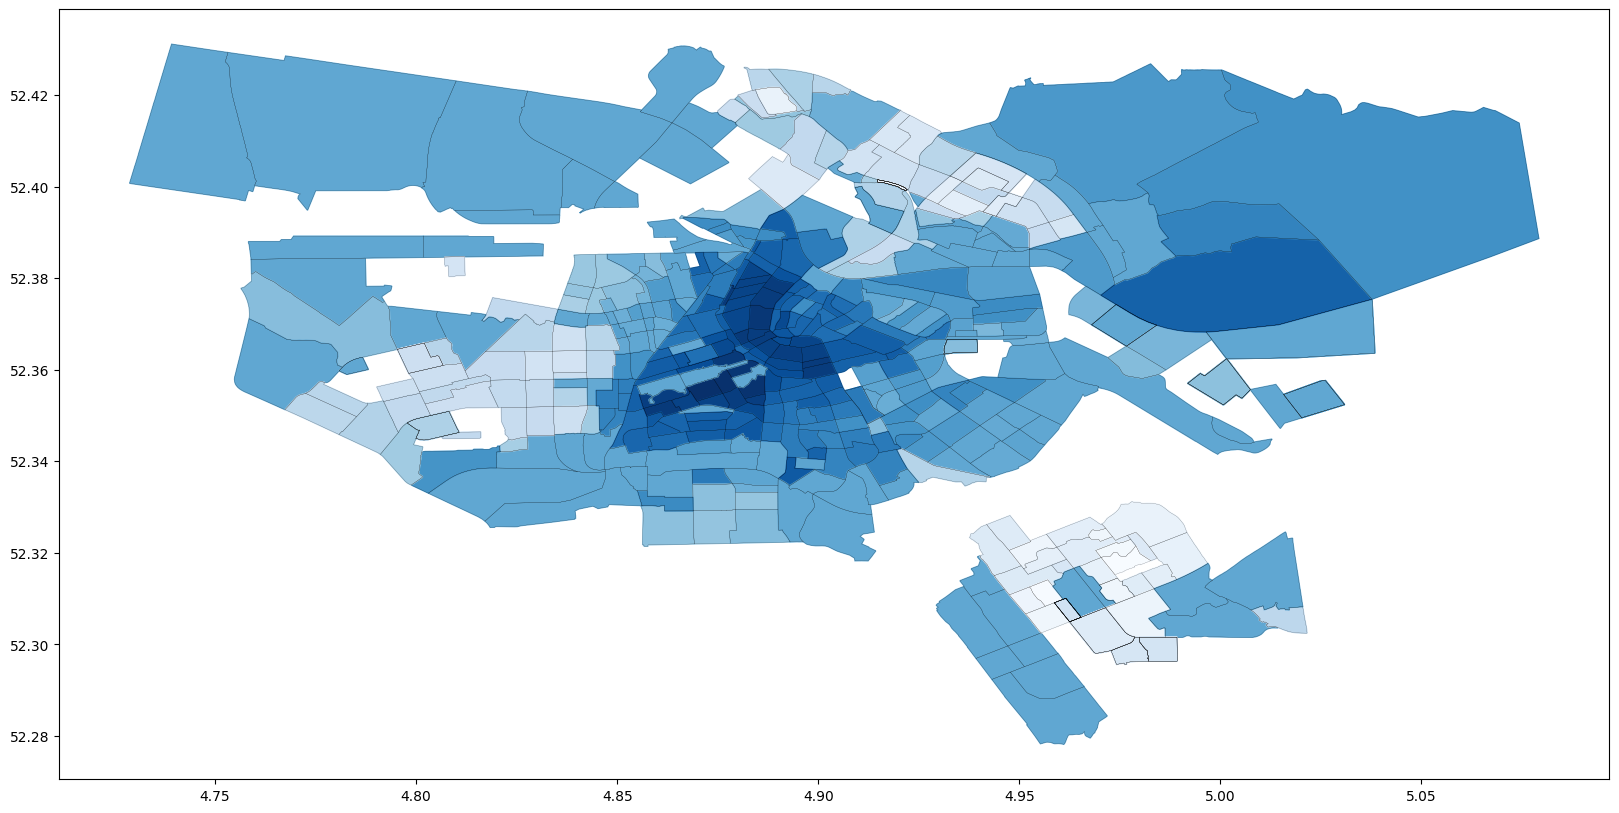

In [15]:
plt.figure(figsize = (20,10))

# Set color map
cmap = mpl.cm.Blues
normalize = mpl.colors.Normalize(vmin=df['woz-value per m2'].min(), vmax=df['woz-value per m2'].max())

for j in range(len(df)):
    s = df['WKT_LNG_LAT'][j]
    s = [i.split(" ") for i in s]
    x = [float(i[0]) for i in s]
    y = [float(i[1]) for i in s]
    z = df['woz-value per m2'][j]
    plt.plot(x,y, color = 'black',linewidth=0.1)
    plt.fill(x,y, color = cmap(normalize(z)))
plt.show()

## As expected, there is a very high spatial correlation!

In [16]:
# Create useful variables

# Distance to City Center

df['dist'] = np.sqrt((df['LNG'][0] - df['LNG'])**2 + (df['LAT'][0] - df['LAT'])**2)

# Weighted average of wuz value around neighbourhood

def distance(x,y):
    '''
    Given some coordinates, return a weighted distance average of the mean WOZ value.
    Weighted distance: distance band weights. d_ij = (1 if neighbour). Minimum distance to be considered a n is given by so that every point has at least one n
    '''
    dist = np.sqrt((x - df['LNG'])**2 + (y - df['LAT'])**2)
    dist = ((dist <= 0.010220719372921737) & (dist != 0))
    dist = (dist * df['woz-value per m2']).mean()
    return dist 

df['wd'] = 0

for i in range(0,len(df)):
    x = df['LNG'][i]
    y = df['LAT'][i]
    df.loc[i, 'wd'] = distance(x,y)

C:\Users\31648\AppData\Local\Temp\ipykernel_27400\3120030754.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '860.2567894112397' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'wd'] = distance(x,y)


# Setting up ML model

In [17]:
# Keep only relevant columns

df = df[['single', 'married, no kids', 'not married, no kids','married, with kids', 'not married, with kids', 'single parent','other', 'total','stadsdeel','m2','wd','dist','woz-value per m2']]

# Set previous index

df.index = ind

# Save as csv

df.to_csv('train.csv')

# We divide all variables to represent them as proportiones of the total

for i in ['single', 'married, no kids', 'not married, no kids','married, with kids', 'not married, with kids', 'single parent','other']:
    df[i] = df[i] / df.total

# Normalize data

def normalization(x):
    return (x - st.mean(x)) / st.stdev(x)

cont = ['single', 'married, no kids', 'not married, no kids','married, with kids', 'not married, with kids', 'single parent','other', 'total','m2','wd','dist','woz-value per m2']

df[cont] = df[cont].apply(normalization)

In [18]:
X = df[['single', 'married, no kids', 'not married, no kids','married, with kids', 'not married, with kids', 'single parent','other', 'total','stadsdeel','m2','wd','dist']]
X = np.array(X)

y = df['woz-value per m2']
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Testing different models

### Random forest

In [19]:
# define the model
rf = RandomForestRegressor(max_depth=2, random_state=0)
# define the model evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
# evaluate the model and collect the scores
n_scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
# report performance
print('MSE: %.3f (%.3f)' % (abs(np.mean(n_scores)), np.std(n_scores)))

MSE: 0.474 (0.128)


### Boosted random forest

In [20]:
# define the model
boost = XGBRFRegressor(n_estimators=100, subsample=0.9, colsample_bynode=0.2, colsample_bytree = 1, max_depth = 14, min_child_weight = 0)
# define the model evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
# evaluate the model and collect the scores
n_scores = cross_val_score(boost, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('MSE: %.3f (%.3f)' % (abs(np.mean(n_scores)), np.std(n_scores)))

MSE: 0.260 (0.105)


### Neural network

In [21]:
var = ['single', 'married, no kids', 'not married, no kids','married, with kids', 'not married, with kids', 'single parent','other', 'total','stadsdeel','m2','wd','dist']

model = keras.Sequential([layers.Dense(64, activation='relu', input_shape=[len(var)]),layers.Dense(64, activation='relu'),layers.Dense(1)])
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])

model.fit(X_train, y_train, epochs = 1000, validation_split = 0.2, verbose=0)

In [22]:
yhat = model.predict(X_test)

4/4 [==============================] - 0s 1ms/step


In [23]:
np.mean((y_test - yhat) ** 2)

2.160597548619312

# The best model in terms of predictive power is the Boosted Random Forest